In [1]:
from elk_generalization.results.viz import get_result_dfs
from elk_generalization.utils import get_quirky_model_name

models = [
    "mistralai/Mistral-7B-v0.1",
]
model_scales = {
    "pythia-410m": 0.41,
    "pythia-1b": 1,
    "pythia-1.4b": 1.4,
    "pythia-2.8b": 2.8,
    "pythia-6.9b": 6.9,
    "pythia-12b": 12,
    "Llama-2-7b-hf": 7,
    "Mistral-7B-v0.1": 7,
}
method_titles = {
    "lr": "LogR",
    "mean-diff": "Diff-in-means",
    "mean-diff-on-pair": "Diff-in-means on contrast pair",
    "lda": "LDA",
    "lr-on-pair": "LogR on contrast pair",
    "ccs": "CCS",
    "crc": "CRC",
    "vincs": "VINCS",
}

ds_names = [
    "capitals",
    "hemisphere",
    "population",
    "sciq",
    "sentiment",
    "nli",
    "authors",
    "addition",
    "subtraction",
    "multiplication",
    "modularaddition",
    "squaring",
]

ds_abbrevs = {
    "capitals": "cap",
    "hemisphere": "hem",
    "population": "pop",
    "sciq": "sciq",
    "sentiment": "snt",
    "nli": "nli",
    "authors": "aut",
    "addition": "add",
    "subtraction": "sub",
    "multiplication": "mul",
    "modularaddition": "mod",
    "squaring": "sqr",
}
# root = "../../experiments-vincs-good/"
root = "/mnt/hdd-0/alexm/elk-generalization/experiments-vincs-good/"


/mnt/ssd-1/alexm/miniconda3/envs/elkg/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Qualitative differences

In [5]:
plot_ds_names = ds_names.copy()
plot_models = models
fr, to = "AE", "AE"
filter_by = "all"
if "H" in fr or "E" in fr:
    plot_ds_names.remove("population")  # difficulty is label
if filter_by == "disagreements":
    plot_ds_names.remove("authors")  # authors is only False for disagreements
weak_only = False
metric = "auroc"
methods = ["vincs",]
# var, inv, cov, supervised weights
vincs_hparams = (1.0, 0.0, 1.0, 0.0)
leace_pseudolabels = True
leace_variants = False
templatization_method = "random"
standardize_templates = True
full_finetuning = False
ensemble = "full"
label_col="alice_label"
rs = dict()
for reporter in methods:
    rs[reporter] = get_result_dfs(plot_models, fr, to, plot_ds_names, label_col=label_col, ensemble=ensemble, filter_by=filter_by, metric=metric, reporter=reporter, root_dir=root, weak_only=weak_only, vincs_hparams=vincs_hparams, leace_pseudolabels=leace_pseudolabels, leace_variants=leace_variants, templatization_method=templatization_method, standardize_templates=standardize_templates, full_finetuning=full_finetuning)

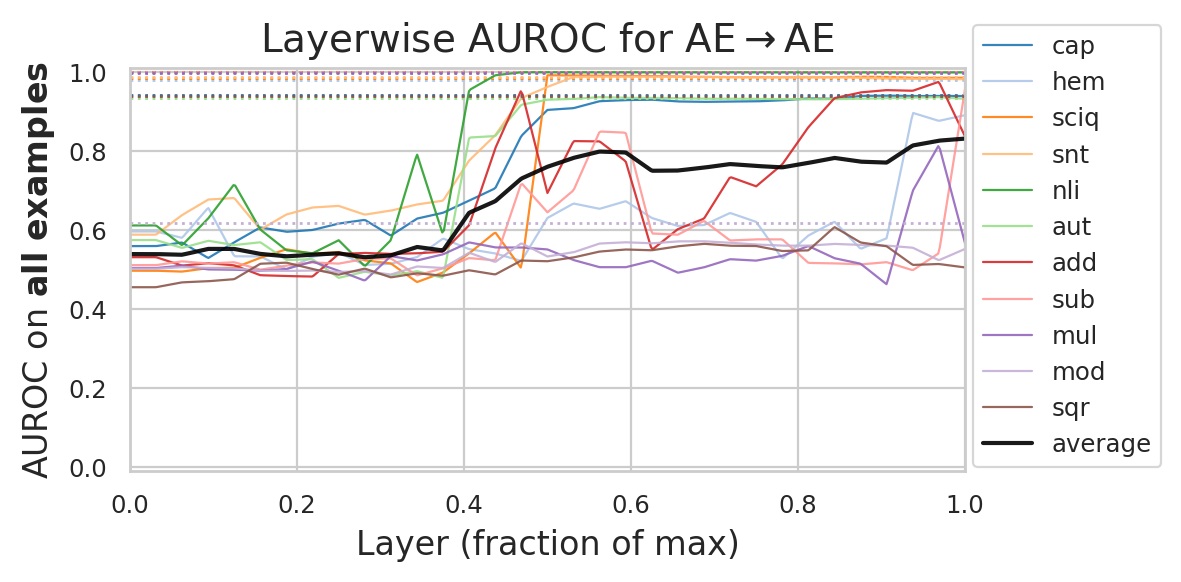

In [6]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")

fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(6, 3), dpi=200)

for i, method in enumerate(methods):
    avg_reporter_results, per_ds_results_dfs, all_result_dfs, avg_lm_result, per_ds_lm_result_dfs, lm_results = rs[method]
    colors = sns.color_palette("tab20", len(per_ds_results_dfs))
    for j, (key, result_df, lm_result) in enumerate(zip(per_ds_results_dfs.keys(), per_ds_results_dfs.values(), per_ds_lm_result_dfs.values())):
        ax.plot(result_df["layer_frac"], result_df[metric], alpha=0.9, color=colors[j], linewidth=0.8, label=ds_abbrevs[key])
        ax.hlines(lm_result, 0, 1, color=colors[j], linewidth=1, linestyle=":")

    # also show the average
    ax.plot(avg_reporter_results["layer_frac"], avg_reporter_results[metric], alpha=0.9, color="black", linewidth=1.5, label="average")

    # turn legend on
    if i == 0:
        ax.legend(loc=[1.01, 0.01])

    if i % 3 == 0:
        lab = {
            "disagree": f"{metric.upper()}" + " on $\\bf{disagreements}$",
            "agree": f"{metric.upper()}" + " on $\\bf{agreements}$",
            "all": f"{metric.upper()}" + " on $\\bf{all\\ examples}$",
        }[filter_by]
        ax.set_ylabel(lab, fontsize=12)
    
    if i == 0:
        ax.set_xlabel("Layer (fraction of max)", fontsize=12)
    
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.01, 1.01)
    if i == 3:
        ax.legend(loc="lower left")

plt.title(f"Layerwise {metric.upper()} for {fr}$\\to${to}" + (" weak only" if weak_only else ""), fontsize=14)
plt.tight_layout()
os.makedirs("../../figures", exist_ok=True)
plt.savefig(f"../../figures/layerwise_auroc_qualitative_{fr}_{to}.pdf")
plt.show()

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from viz import earliest_informative_layer
import os
import numpy as np

current_args = dict(
    ds_names=ds_names.copy(),
    models=models,
    fr="AE",
    to="BH",
    filter_by="all",
    weak_only=False,
    metric="auroc",
    reporter="vincs",
    leace_pseudolabels=True,
    leace_variants=True,
    templatization_method="random",
    standardize_templates=False,
    full_finetuning=False,
    ensemble="full",
    label_col="alice_label",
    root_dir=root,
)
use_eil=True
if "H" in current_args["fr"] or "E" in current_args["fr"]:
    current_args["ds_names"].remove("population")  # difficulty is label
if current_args["filter_by"] == "disagreements":
    current_args["ds_names"].remove("authors")  # authors is only False for disagreements

hparams_list = hparams = [
    (var * (inv + cov + supervised), inv, cov, supervised)
    for var in [0, 1]
    for inv in [0, 0.25, 1, 4]
    for cov in [0, 1,]
    for supervised in [0, 0.25, 1, 4]
]

dfs = []
for frame, hparams in enumerate(hparams_list):
    
    print("CURRENT HPARAMS:", hparams)
    try:
        # make a df with a column for auroc on middle layer, and a column for method, and column for transfer,
        # where each row is a model/template/method combo
        df = []        
        _, _, result_dfs, _, _, _ = get_result_dfs(vincs_hparams=hparams, **current_args)
        # pick layer on source distribution with all examples, measured against source labels
        id_args = current_args.copy()
        id_args["filter_by"] = "all"
        id_args["to"] = current_args["fr"]
        id_args["label_col"] = "label"
        _, _, id_result_dfs, _, _, _ = get_result_dfs(vincs_hparams=hparams, **id_args)
        for model in models:
            for ds_name in current_args["ds_names"]:
                if (model, ds_name) not in result_dfs or (model, ds_name) not in id_result_dfs:
                    print(f"Skipping {model}-{ds_name} due to missing data")
                    continue
                if id_result_dfs[(model, ds_name)].isna().any().any():
                    print(f"Skipping {model}-{ds_name} due to NaN")
                    continue
                if use_eil:
                    layer_idx = earliest_informative_layer(id_result_dfs[(model, ds_name)], thresh=0.95)
                    auroc = result_dfs[(model, ds_name)]["auroc"].values[layer_idx]
                    sum_last_3 = hparams[1] + hparams[2] + hparams[3]
                    if sum_last_3 == 0:
                        continue
                    df.append({
                        "auroc": auroc,
                        "method": method_titles[current_args['reporter']].replace("LogR on contrast pair", "LogR on\ncont. pair").replace("Diff-in-means on contrast pair", "Diff-in-means\non cont. pair"),
                        "transfer": f"{current_args['fr']}$\\to${current_args['to']}",
                        "model": model,
                        "dataset": ds_name,
                        "w_var": hparams[0],
                        "w_inv": hparams[1] / sum_last_3,
                        "w_cov": hparams[2] / sum_last_3,
                        "w_sup": hparams[3] / sum_last_3,
                    })
                else:
                    # use all layers
                    for layer_idx in range(len(result_dfs[(model, ds_name)])):
                        auroc = result_dfs[(model, ds_name)]["auroc"].values[layer_idx]
                        sum_last_3 = hparams[1] + hparams[2] + hparams[3]
                        if sum_last_3 == 0:
                            continue
                        df.append({
                            "auroc": auroc,
                            "method": method_titles[current_args['reporter']].replace("LogR on contrast pair", "LogR on\ncont. pair").replace("Diff-in-means on contrast pair", "Diff-in-means\non cont. pair"),
                            "transfer": f"{current_args['fr']}$\\to${current_args['to']}",
                            "model": model,
                            "dataset": ds_name,
                            "w_var": hparams[0],
                            "w_inv": hparams[1] / sum_last_3,
                            "w_cov": hparams[2] / sum_last_3,
                            "w_sup": hparams[3] / sum_last_3,
                            "layer_frac": layer_idx / len(result_dfs[(model, ds_name)]),
                            "layer_idx": layer_idx,
                        })
    except FileNotFoundError as e:
        print(f"Experiment not found: {e}")
        continue
    
    df = pd.DataFrame(df)

    dfs.append(df)
df = pd.concat(dfs)

CURRENT HPARAMS: (0, 0, 0, 0)
CURRENT HPARAMS: (0.0, 0, 0, 0.25)
CURRENT HPARAMS: (0, 0, 0, 1)
CURRENT HPARAMS: (0, 0, 0, 4)
CURRENT HPARAMS: (0, 0, 1, 0)
CURRENT HPARAMS: (0.0, 0, 1, 0.25)
CURRENT HPARAMS: (0, 0, 1, 1)
CURRENT HPARAMS: (0, 0, 1, 4)
CURRENT HPARAMS: (0.0, 0.25, 0, 0)
CURRENT HPARAMS: (0.0, 0.25, 0, 0.25)
CURRENT HPARAMS: (0.0, 0.25, 0, 1)
CURRENT HPARAMS: (0.0, 0.25, 0, 4)
CURRENT HPARAMS: (0.0, 0.25, 1, 0)
CURRENT HPARAMS: (0.0, 0.25, 1, 0.25)
CURRENT HPARAMS: (0.0, 0.25, 1, 1)
CURRENT HPARAMS: (0.0, 0.25, 1, 4)
CURRENT HPARAMS: (0, 1, 0, 0)
CURRENT HPARAMS: (0.0, 1, 0, 0.25)
CURRENT HPARAMS: (0, 1, 0, 1)
CURRENT HPARAMS: (0, 1, 0, 4)
CURRENT HPARAMS: (0, 1, 1, 0)
CURRENT HPARAMS: (0.0, 1, 1, 0.25)
CURRENT HPARAMS: (0, 1, 1, 1)
CURRENT HPARAMS: (0, 1, 1, 4)
CURRENT HPARAMS: (0, 4, 0, 0)
CURRENT HPARAMS: (0.0, 4, 0, 0.25)
CURRENT HPARAMS: (0, 4, 0, 1)
CURRENT HPARAMS: (0, 4, 0, 4)
CURRENT HPARAMS: (0, 4, 1, 0)
CURRENT HPARAMS: (0.0, 4, 1, 0.25)
CURRENT HPARAMS: (0, 4, 

In [85]:
df["auroc"].mean()

0.7503828918051716

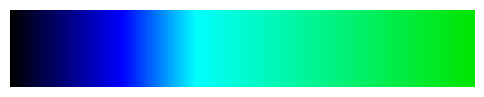

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define colors at key points
start, end = (0.62 - 0.5) * 2, (0.7 - 0.5) * 2
cdict = {
    'red':   [(0.0,  0.0, 0.0),
              (start, .0, .0),
              (end, .0, .0),
              (1.0,  .0, .0)],
    
    'green': [(0.0,  0.0, 0.0),
              (start, 0.0, 0.0),
              (end, 1.0, 1.0),
              (1.0,  .9, .9)],
    
    'blue':  [(0.0,  0.0, 0.0),
              (start, 1.0, 1.0),
              (end, 1.0, 1.0),
              (1.0,  0.0, 0.0)]
}

# Create the colormap
custom_cmap = LinearSegmentedColormap('CustomMap', segmentdata=cdict, N=256)

# Plot to visualize the colormap
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

fig, ax = plt.subplots(figsize=(6, 1))
ax.imshow(gradient, aspect='auto', cmap=custom_cmap)
ax.set_axis_off()

plt.show()


/mnt/ssd-1/alexm/miniconda3/envs/elkg/lib/python3.11/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


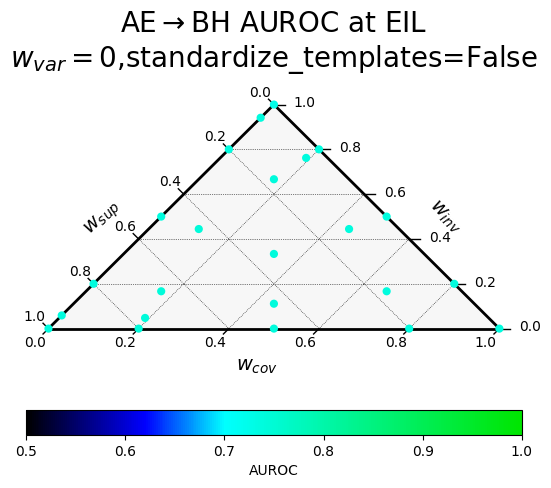

In [88]:
import random
import ternary
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, BoundaryNorm
from typing import Literal

def float_to_color(x, alpha=1.0):
    c = custom_cmap(x)
    return (*c[:3], alpha)

vmin, vmax = 0.5, 1
w_var: Literal[0, 1] = 0
sub_df = (df[df["w_var"] == 0] if not w_var else df[df["w_var"] > 0])
jitter_scale = 0.015
w_covs = sub_df["w_cov"].values + np.random.normal(0, jitter_scale, len(sub_df))
w_invs = sub_df["w_inv"].values + np.random.normal(0, jitter_scale, len(sub_df))
w_sups = sub_df["w_sup"].values + np.random.normal(0, jitter_scale, len(sub_df))
aurocs = sub_df["auroc"].values
colors = [float_to_color(auroc, alpha=0.4) for auroc in Normalize(vmin=vmin, vmax=vmax)(aurocs)]

avg_df = sub_df.groupby(["w_cov", "w_inv", "w_sup"])["auroc"].mean().reset_index()
avg_w_covs = avg_df["w_cov"].values
avg_w_invs = avg_df["w_inv"].values
avg_w_sups = avg_df["w_sup"].values
avg_aurocs = avg_df["auroc"].values
avg_colors = [float_to_color(auroc) for auroc in Normalize(vmin=vmin, vmax=vmax)(avg_aurocs)]

## Boundary and Gridlines
figure, tax = ternary.figure(scale=1)
tax.set_title(f"{current_args['fr']}$\\to${current_args['to']} AUROC{' at EIL' if use_eil else ''}\n$w_{{var}} = {w_var}$,standardize_templates={current_args['standardize_templates']}",
               fontsize=20, y=1.08)
tax.boundary(linewidth=2.0)
tax.gridlines(color="black", multiple=0.2)

# Set Axis labels and Title
fontsize = 14
offset = 0.14
tax.left_axis_label("$w_{sup}$", fontsize=fontsize, offset=offset)
tax.right_axis_label("$w_{inv}$", fontsize=fontsize, offset=offset)
tax.bottom_axis_label("$w_{cov}$", fontsize=fontsize, offset=offset)

# Set ticks
tax.ticks(axis='lbr', linewidth=1, multiple=0.2, offset=0.024, tick_formats="%.1f")

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()

# Plot corner labels

# n = 400
# background_points = list(zip(w_covs, w_invs, w_sups))
# sample_indices = random.sample(range(len(background_points)), min(n, len(background_points)))
# background_points = [background_points[i] for i in sample_indices]
# colors = [colors[i] for i in sample_indices]

# tax.scatter(background_points, marker='.', color=colors, s=15, alpha=.5)
tax.scatter(list(zip(avg_w_covs, avg_w_invs, avg_w_sups)), marker='.', color=avg_colors, s=60, linewidths=2.0, zorder=10)

# colorbar
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
ax = plt.gca()
plt.colorbar(sm, ax=ax, orientation='horizontal', label="AUROC")
# plt.tight_layout()
plt.savefig(f"../../figures/ternary_{current_args['fr']}_{current_args['to']}_wvar_{w_var}_standardize_templates_{current_args['standardize_templates']}{'_eil' if use_eil else ''}.png", bbox_inches="tight")

# turn off mpl axes
plt.axis('off')

# Here you could also add other data points, etc.
# Showing the plot
ternary.plt.show()

# Scatter plot for ID and OOD performance

In [18]:
from collections import defaultdict
from scipy.stats import linregress
import torch
from tqdm import tqdm
import pandas as pd
from pathlib import Path

root = Path("../../experiments/")
current_args = dict(
    ds_names=ds_names.copy(),
    models=models,
    filter_by="all",
    weak_only=False,
    metric="auroc",
    reporter="vincs",
    leace_pseudolabels=True,
    leace_variants=False,
    templatization_method="random",
    standardize_templates=False,
    full_finetuning=False,
    ensemble="full",
    label_col="alice_label",
)
current_args["ds_names"].remove("population")

hparams_list = hparams = [
    (var * (inv + cov + supervised), inv, cov, supervised)
    for var in [0, 1]
    for inv in [0, 0.25, 1, 4]
    for cov in [0, 1,]
    for supervised in [0, 0.25, 1, 4]
]
# hparams_list = [
#     (1, 0, 1, 0),  # CRC, should have "on-the-line" property
#     (0, 0, 0, 1),  # mean-diff on contrast pair, ~shouldn't have "on-the-line" property
#     (1, 0, 1, 1),  # convex combination of CRC and mean-diff
# ]

id_aurocs = defaultdict(list)
ood_aurocs = defaultdict(list)
df_list = []
regressions = dict()
for hparams in tqdm(hparams_list, total=len(hparams_list)):
    sum_last_3 = hparams[1] + hparams[2] + hparams[3]
    if sum_last_3 == 0:
        continue
    normalized_hparams = (int(hparams[0] > 0), hparams[1] / sum_last_3, hparams[2] / sum_last_3, hparams[3] / sum_last_3)
    for (fr, to) in [("AE", "AE"), ("AE", "BH")]:
        _, _, result_dfs, _, _, _ = get_result_dfs(fr=fr, to=to, vincs_hparams=hparams, **current_args)
        for model in current_args['models']:
            for ds_name in current_args["ds_names"]:
                aucs = result_dfs[(model, ds_name)]["auroc"].values
                if to == "AE" and fr == "AE":
                    id_aurocs[normalized_hparams].extend(aucs)
                elif to == "BH" and fr == "AE":
                    ood_aurocs[normalized_hparams].extend(aucs)
                else:
                    raise ValueError("Unexpected experiment")
                
                quirky_model_id, quirky_model_last = get_quirky_model_name(ds_name, model, templatization_method=current_args['templatization_method'], standardize_templates=current_args['standardize_templates'], full_finetuning=current_args['full_finetuning'])
                random_results = torch.load(root / quirky_model_last / to / "test" / f"{fr}_random_aucs_against_{current_args['label_col']}s_full.pt", map_location="cpu")

                for layer, (auc, random_auc) in enumerate(zip(aucs, random_results)):
                    df_list.append({
                        "auc": auc,
                        "random_auc": random_auc['mean'],
                        "layer": layer,
                        "model": model,
                        "dataset": ds_name,
                        "transfer": f"{fr}$\\to${to}",
                        "w_var": hparams[0],
                        "w_inv": hparams[1] / sum_last_3,
                        "w_cov": hparams[2] / sum_last_3,
                        "w_sup": hparams[3] / sum_last_3,
                    })
    
    lin = linregress(id_aurocs[normalized_hparams], ood_aurocs[normalized_hparams])
    regressions[normalized_hparams] = lin
df = pd.DataFrame(df_list)

100%|██████████| 64/64 [00:52<00:00,  1.22it/s]


Text(0.5, 1.0, 'templatization_method=random, standardize_templates=False, leace_pseudo=True, leace_variants=False')

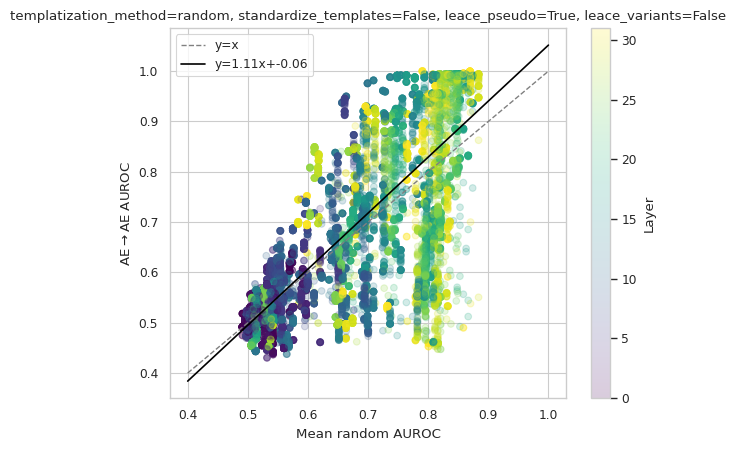

In [19]:
transfer = "AE$\\to$AE"
plt_df = df[df["transfer"] == transfer]
lin = linregress(plt_df["random_auc"], plt_df["auc"])

plt.scatter(plt_df["random_auc"], plt_df["auc"], alpha=0.2, c=plt_df["layer"], cmap="viridis")
plt.colorbar(label="Layer")
plt.plot([0.4, 1], [0.4, 1], color="grey", linestyle="--", label="y=x", linewidth=1)
plt.plot([0.4, 1], [lin.intercept + 0.4 * lin.slope, lin.intercept + lin.slope], color="black", linestyle="-", label=f"y={lin.slope:.2f}x+{lin.intercept:.2f}")
plt.legend()
plt.xlabel("Mean random AUROC")
plt.ylabel(f"{transfer} AUROC")
plt.title(f"templatization_method={current_args['templatization_method']}, standardize_templates={current_args['standardize_templates']}, leace_pseudo={current_args['leace_pseudolabels']}, leace_variants={current_args['leace_variants']}")

In [20]:
print(f"standardize_templates={current_args['standardize_templates']}, leace_pseudolabels={current_args['leace_pseudolabels']}, leace_variants={current_args['leace_variants']}")
print(f"w_var\tw_inv\tw_cov\tw_sup\tslope\tr\tid_auc\tood_auc")
sorted_hparams = sorted(id_aurocs.keys(), key=lambda h: -regressions[h].slope)
for hparams in sorted_hparams:
    mean_id_auc = np.mean(id_aurocs[hparams])
    mean_ood_auc = np.mean(ood_aurocs[hparams])
    print("\t".join(map(lambda x: f"{round(x,2)}", hparams)), f"\t{regressions[hparams].slope:.3f}\t{regressions[hparams].rvalue:.3f}\t{mean_id_auc:.3f}\t{mean_ood_auc:.3f}")

standardize_templates=False, leace_pseudolabels=True, leace_variants=False
w_var	w_inv	w_cov	w_sup	slope	r	id_auc	ood_auc
0	0.94	0.0	0.06 	0.823	0.871	0.704	0.648
0	0.0	0.0	1.0 	0.823	0.871	0.704	0.648
0	0.5	0.0	0.5 	0.823	0.871	0.704	0.648
0	0.8	0.0	0.2 	0.823	0.871	0.704	0.648
0	0.2	0.0	0.8 	0.823	0.871	0.704	0.648
0	0.06	0.0	0.94 	0.823	0.871	0.704	0.648
1	0.94	0.0	0.06 	0.817	0.846	0.681	0.632
1	1.0	0.0	0.0 	0.817	0.846	0.681	0.632
1	0.8	0.0	0.2 	0.817	0.846	0.681	0.632
1	0.5	0.0	0.5 	0.816	0.846	0.681	0.633
1	0.06	0.0	0.94 	0.815	0.845	0.681	0.633
1	0.2	0.0	0.8 	0.815	0.845	0.681	0.633
1	0.0	0.0	1.0 	0.815	0.845	0.681	0.633
1	0.44	0.11	0.44 	0.814	0.841	0.678	0.629
1	0.67	0.17	0.17 	0.810	0.838	0.676	0.627
1	0.17	0.17	0.67 	0.810	0.838	0.676	0.627
1	0.05	0.19	0.76 	0.806	0.836	0.675	0.626
1	0.76	0.19	0.05 	0.806	0.836	0.675	0.626
1	0.0	0.2	0.8 	0.804	0.835	0.675	0.626
1	0.8	0.2	0.0 	0.803	0.835	0.675	0.626
1	0.33	0.33	0.33 	0.772	0.816	0.668	0.618
1	0.44	0.44	0.11 	0.755	0.803	0.6

In [ ]:
linregress([hparams[0] for hparams in sorted_hparams], [regressions[hparams].slope for hparams in sorted_hparams])
# linregress([hparams[3] for hparams in sorted_hparams], [np.mean(id_aurocs[hparams]) for hparams in sorted_hparams])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
colors = sns.color_palette("Set2")

plt.figure(figsize=(4, 4), dpi=150)
n_show = len(id_aurocs[hparams])
for i, (hparams, name) in enumerate(zip(id_aurocs, ["CRC", "Diff-in-means", "combo"])):
    sample = np.random.choice(len(id_aurocs[hparams]), n_show, replace=False)
    for j, idx in enumerate(sample):
        plt.scatter(id_aurocs[hparams][idx], ood_aurocs[hparams][idx], label=name if j == 0 else None, alpha=0.5, s=5, zorder=np.random.randint(0, 6), c=colors[i])
plt.plot([0, 2], [0, 2], color="black", linestyle="--", linewidth=0.5)
plt.axhline(0.5, color="grey", linestyle="--", linewidth=0.5)
plt.xlim(0.35, 1.02)
plt.ylim(-0.02, 1.02)
plt.xlabel("AUROC on AE (no transfer)", fontsize=13)
plt.ylabel("Transfer AUROC for AE$\\to$BH", fontsize=13)
os.makedirs("../../figures", exist_ok=True)
plt.legend(fontsize=12, loc="lower left")
title = f"leace={current_args['use_leace']}, standardize_templates={current_args['standardize_templates']}"
plt.title(title, fontsize=13)
plt.tight_layout()
plt.show()

# Random classifier

In [ ]:
import torch
from pathlib import Path
from viz import interpolate
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from elk_generalization.utils import get_quirky_model_name

# set color palette
palette = sns.color_palette("tab20", 20)
sns.set_palette(palette)
fr, to = "AE", "BH"
against_col = "alice_label"
root = Path("../../experiments")
# ceiling_root = Path("../../experiments-ceiling")
plt.figure(figsize=(5, 3.1), dpi=100)
cmap = plt.get_cmap('coolwarm')
random_ds_names = ds_names.copy()
random_ds_names.remove("population")
standardize_templates = False
full_finetuning = False
templatization_method = "random"

for q_idx in [30, 20, 17, 16, 15, 14, 13, 10, 0,]:
    layers_dict = dict()
    aurocs_dict = dict()
    for model in models:
        for ds_name in random_ds_names:
            model_last = model.split("/")[-1]
            try:
                quirky_model_id, quirky_model_last = get_quirky_model_name(ds_name, model_last, templatization_method=templatization_method, standardize_templates=standardize_templates, full_finetuning=full_finetuning)
                results = torch.load(root / quirky_model_last / to / "test" / f"{fr}_random_aucs_against_{against_col}s_full.pt", map_location="cpu")
            except FileNotFoundError as e:
                print(f"skipping {quirky_model_id}", e)
                continue
            aurocs = [list(results[i]["quantiles"].values())[q_idx] for i in range(len(results))]
            
            if not np.isfinite(np.array(aurocs)).all():
                print(f"skipping {quirky_model_id} due to NaN")
                continue
            layers_dict[(model, ds_name)] = np.arange(len(results))
            aurocs_dict[(model, ds_name)] = aurocs

    layer_fracs, avg_aurocs = interpolate(list(layers_dict.values()), list(aurocs_dict.values()), layers_dict.keys(), 501)

    q = list(results[0]["quantiles"].keys())[q_idx]
    lab = "$2^{" + str(int(np.log2(q))) + "}$" if q <= 0.5 else "$1-2^{" + str(int(np.log2(1 - q))) + "}$"
    plt.plot(layer_fracs, avg_aurocs, label=lab, linewidth=2, color=cmap(q))

# avg_reporter_results, _, _, _, _, _ = get_result_dfs(models, "B", "BH", random_ds_names, label_col="alice_label", filter_by="all", metric="auroc", reporter="lr", root_dir=ceiling_root, weak_only=False)
# plt.plot(avg_reporter_results["layer_frac"], avg_reporter_results["auroc"], label="LogR ceiling", linewidth=2, color="black", linestyle="--")

# turn on horizontal grid
plt.grid(axis="y")

plt.legend(loc=[1.07, -0.1], title="quantile", fontsize=11)
plt.ylim(-0.01, 1.01)
plt.xlim(0, 1)
plt.xlabel("Layer (fraction of max)", fontsize=13)
plt.ylabel("AUROC on\nall examples", fontsize=13)
plt.tight_layout()
plt.title(f"{fr}$\\to${to} random baseline", fontsize=13)
plt.savefig(f"../../figures/layerwise_auroc_random_{fr}_{to}.pdf", bbox_inches="tight")